# LocImpBranchPro: inference of R_t

In [48]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd

num_timepoints = 30 # number of days for incidence data

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [43]:
# Construct LocImpBranchProModel object
epsilon = 0

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpBranchProModel(initial_r, serial_interval, epsilon)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[ 100.    0.   30.   92.  104.  169.  194.  254.  333.  375.  459.  553.
  638.  728.  882. 1004.  389.  419.  385.  349.  289.  263.  232.  191.
  161.  165.  148.  143.  124.  125.]


In [44]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

In [46]:
# Posterior of R_t
#epsilon = 0.5

tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

# print(len(serial_interval))
# print(len(locally_infected_cases))
# print(len(imported_cases))

i=0
for t in range(R_t_start,num_timepoints+1):
#     print(t)
    shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
    sum_var_loc = 0
    sum_var_imp = 0
    for k in range(t-tau,t+1):
        vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
        vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
        vec3 = serial_interval[:k] # w_1, ... , w_k
        
#         print(len(vec1))
#         print(len(vec2))
#         print(len(vec2))
#         print(np.multiply(vec1,vec3))
#         print(np.multiply(vec2,vec3))
        sum_var_loc += math.fsum( np.multiply(vec1,vec3) )
        sum_var_imp += math.fsum( np.multiply(vec2,vec3) )
    rate.append( 1/b + sum_var_loc + (1 + epsilon) * sum_var_imp)
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape, scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)

# print(shape)
# print(rate)
# print(mean)

Text(0.5, 1.0, 'Inferred effective reproduction number vs. time')

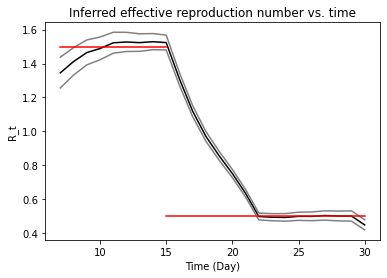

In [47]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1], num_timepoints+1))

fig = plt.figure()
plt.plot(np.arange(R_t_start,num_timepoints+1), mean, 'k')
plt.plot(np.arange(R_t_start,num_timepoints+1), post_dist_interval[0], 'gray')
plt.plot(np.arange(R_t_start,num_timepoints+1), post_dist_interval[1], 'gray')
plt.plot(np.arange(R_t_start, start_times[1]+1), L1*[1.5], 'red')
plt.plot(np.arange(start_times[1], num_timepoints+1), L2*[0.5], 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')

In [51]:
# Same inference, but using the LocImpBranchProPosterior
epsilon = 0
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

Text(0.5, 1.0, 'Inferred effective reproduction number vs. time')

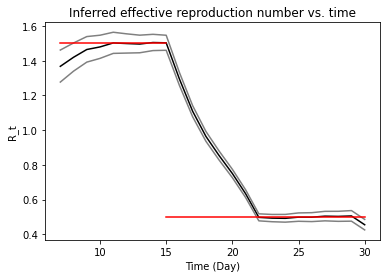

In [52]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1], num_timepoints+1))

fig = plt.figure()
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Mean'], 'k')
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Lower bound CI'], 'gray')
plt.plot(np.arange(R_t_start,num_timepoints+1), intervals['Upper bound CI'], 'gray')
plt.plot(np.arange(R_t_start, start_times[1]+1), L1*[1.5], 'red')
plt.plot(np.arange(start_times[1], num_timepoints+1), L2*[0.5], 'red')
plt.xlabel('Time (Day)')
plt.ylabel('R_t')
plt.title('Inferred effective reproduction number vs. time')